In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle as pkl


In [22]:
def relabel(labels):
    '''
    task wise relabel the dataset as combination of 0's and 1's
    '''
    new_labels = np.empty((0, labels.shape[0]), dtype=np.float32)
    for task in range(10):
        positives = np.where(labels[:,task] == 1)[0]
        task_labels = np.zeros(labels.shape[0], dtype=np.float32)
        task_labels[positives] = 1.0
        new_labels = np.vstack((new_labels, task_labels))
#     new_labels = tf.convert_to_tensor(new_labels, dtype=tf.float32)
    return new_labels

def batch_loader(labels, batch_size, class_bal=False):
    '''
    load random batches of data
    '''
    # if class balance is not required in every batch
    if not class_bal:
        indices = np.arange(labels.shape[0])
        for _ in range(5): np.random.shuffle(indices)
        batches = np.asarray(list(divide_chunks(indices, batch_size)))
        return batches
    
    # if class balance is needed in every batch
    else:
        positives = np.where(labels==1)[0]
        negatives = np.arange(labels.shape[0])
        negatives = np.delete(negatives, positives)
        np.random.shuffle(negatives)
        np.random.shuffle(positives)
        task_batch = []
        # create batches by iteratively scraping out chunks out of positives array
        while positives.shape[0] > 0:
            if len(positives) >= batch_size/2:
                # create a batch such that positive (batch_size/2) is added with sampled negatives (batch_size/2)
                temp = np.concatenate((positives[:batch_size//2], np.random.choice(negatives, batch_size//2)))
                positives = positives[batch_size//2: ]
            else:
                # for the last batch where no. of positive could be < batch_size
                temp = np.concatenate((positives, np.random.choice(negatives, len(positives))))
                positives = np.array([])
            np.random.shuffle(temp)
            task_batch.append(temp)
        return np.asarray(task_batch)

def custom_bce(y, p, offset=1e-7): #1e-10
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = -tf.reduce_mean(y * tf.math.log(p_) + (1.0 - y) * tf.math.log(1.0 - p_), axis=1)
    return tf.reduce_mean(vec_bce)/y.shape[0]

def custom_KLD(q, p, offset=1e-7): # q is model predictive/approximating distribution, p is target distribution
    q_ = tf.clip_by_value(q, offset, 1 - offset)
    p_ = tf.clip_by_value(p, offset, 1 - offset)
    vec_bce = tf.reduce_sum(p_ * (tf.math.log(p_) - tf.math.log(q_)))
    return tf.reduce_sum(vec_bce)/p.shape[0]


trainX = pd.read_csv('datasets/mnist/trainX.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
trainY = pd.read_csv('datasets/mnist/trainY.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
testX = pd.read_csv('datasets/mnist/testX.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
testY = pd.read_csv('datasets/mnist/testY.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
validX = pd.read_csv('datasets/mnist/validX.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()
validY = pd.read_csv('datasets/mnist/validY.tsv', sep="\t", header=None, index_col=False, dtype=np.float32).to_numpy()

trainY = relabel(trainY)
testY = relabel(testY)
validY = relabel(validY)

class Network(object):
    
    def __init__(self, n_layers):
        self.params = []
        self.W1 = tf.Variable(
            tf.random.normal([n_layers[0], n_layers[1]], stddev=0.1),
            name='W1')
        #         self.b1 = tf.Variable(tf.random.normal([n_layers[1]], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='b1')
        self.b1 = tf.Variable(tf.zeros([1, n_layers[1]]))
        self.W2 = tf.Variable(
            tf.random.normal([n_layers[1], n_layers[2]], stddev=0.1),
            name='W2')
        #         self.b2 = tf.Variable(tf.random.normal([n_layers[2]], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='b2')
        self.b2 = tf.Variable(tf.zeros([1, n_layers[2]]))
        self.W3 = tf.Variable(
            tf.random.normal([n_layers[2], n_layers[3]],stddev=0.1),
            name='W3')
        #         self.b3 = tf.Variable(tf.random.normal([n_layers[3]], mean=0.0, stddev=0.1, dtype=tf.dtypes.float32, seed=0), name='b3')
        self.b3 = tf.Variable(tf.zeros([1, n_layers[3]]))
        self.params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        
    def forward(self, x):
        X_tf = tf.cast(x, dtype=tf.float32)
        Z1 = tf.matmul(X_tf, self.W1) + self.b1
        Z1 = tf.nn.relu(Z1)
        Z2 = tf.matmul(Z1, self.W2) + self.b2
        Z2 = tf.nn.relu(Z2)
        Z3 = tf.matmul(Z2, self.W3) + self.b3
        Y = tf.nn.sigmoid(Z3)
        return Y
    
    def loss(self, y_true , y_pred):
        '''
        y_pred - Tensor of shape (batch_size, size_output)
        y_true - Tensor of shape (batch_size, size_output)
        '''
        y_true_tf = tf.cast(tf.reshape(y_true, (-1, 1)), dtype=tf.float32)
        y_pred_tf = tf.cast(tf.reshape(y_pred, (-1, 1)), dtype=tf.float32)
        return tf.reduce_mean(tf.compat.v1.losses.log_loss(y_true_tf, y_pred_tf))
    
    def backward(self, x,y):
        optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
        with tf.GradientTape() as tape:
            predicted = self.forward(x)
            current_loss = self.loss(y, predicted)
        grads = tape.gradient(current_loss, self.params)
        optimizer.apply_gradients(zip(grads, self.params),
                                  global_step=tf.compat.v1.train.get_or_create_global_step())

train_losses = {}
test_losses = {}
valid_losses = {}
train_accuracy = {}
valid_accuracy = {}
test_accuracy = {}
n_tasks = 2
n_epochs = 5
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)
net = Network([784, 312, 128, 1])

for t in range(n_tasks):
    train_losses[t] = []
    valid_losses[t] = []
    train_accuracy[t] = []
    valid_accuracy[t] = []
    test_losses[t] = []
    test_accuracy[t] = []
    
def train_metrics():
    for t in range(n_tasks):
        train_loss = 0
        train_acc = 0
        size = 0
        batches = batch_loader(trainY[t], 50, class_bal=True)
        for batch in batches:
            size += batch.shape[0]
            output = net.forward(trainX[batch])
            # try:
            #     output = output.numpy().reshape((50,))
            # except:
            #     output = output.numpy().reshape((14,))
            train_loss += net.loss(trainY[t, batch], output) * batch.shape[0]
            #         print('train output:', output)
            # train_loss += custom_bce(trainY[task, batch], output) * batch.shape[0]
            output = output.numpy().reshape(-1)
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            train_acc += np.sum(output == trainY[t, batch])

        train_accuracy[t].append(train_acc/size)
        train_losses[t].append(train_loss / size)
        
def valid_metrics():
    for t in range(n_tasks):
        valid_loss = 0
        valid_acc = 0
        size = 0
        batches = batch_loader(validY[t], 50, class_bal=True)
        for batch in batches:
            size += batch.shape[0]
            output = net.forward(validX[batch])
            # try:
            #     output = output.numpy().reshape((50,))
            # except:
            #     output = output.numpy().reshape((14,)
            valid_loss += net.loss(validY[t, batch], output) * batch.shape[0]
            output = output.numpy().reshape(-1)
            output[output >= 0.5] = 1
            output[output < 0.5] = 0
            valid_acc += np.sum(output == validY[t, batch])
            # try:
            #
            # except:

            # valid_loss += custom_bce(validY[task, batch], output) * batch.shape[0]

        valid_losses[t].append(valid_loss/size)
        valid_accuracy[t].append(valid_acc/size)
    
train_metrics()
valid_metrics()
    
tqdm.write('Running Tasks')
for task in tqdm(range(n_tasks)):
    for epoch in range(n_epochs):
        batches = batch_loader(trainY[task], 50, class_bal=True)
        for batch in batches:
            preds = net.forward(trainX[batch])
            batch_loss = net.loss(trainY[task, batch], preds)
            net.backward(trainX[batch],trainY[task, batch])
        
        train_metrics()
        valid_metrics()

for t in range(n_tasks):
    test_loss = 0
    test_acc = 0
    size = 0
    batches = batch_loader(testY[t], 50, class_bal=True)
    for batch in batches:
        size += batch.shape[0]
        output = net.forward(testX[batch])
        # try:
        #     output = output.numpy().reshape((50,))
        # except:
        #     output = output.numpy().reshape((14,))
        test_loss += net.loss(testY[t, batch], output) * batch.shape[0]
        #         print('train output:', output)
        # train_loss += custom_bce(trainY[task, batch], output) * batch.shape[0]
        output = output.numpy().reshape(-1)
        output[output >= 0.5] = 1
        output[output < 0.5] = 0
        test_acc += np.sum(output == testY[t, batch])

    test_accuracy[t].append(test_acc/size)
    test_losses[t].append(test_loss / size)
    

data_dict = {'train_loss': train_losses,
             'valid_loss': valid_losses,
             'test_loss': test_losses,
             'train_acc': train_accuracy,
             'valid_acc': valid_accuracy,
             'test_acc': test_accuracy
            }

pkl.dump(data_dict, open('mlp_data_dict.pkl', 'wb'))
print('Experiment completed')


  0%|          | 0/2 [00:00<?, ?it/s]

Running Tasks


100%|██████████| 2/2 [00:29<00:00, 14.81s/it]

Experiment completed


In [17]:
data_dict = pkl.load(open('results/mlp_data_dict.pkl', 'rb'))
data_dict.keys()

dict_keys(['train_loss', 'valid_loss', 'test_loss', 'train_acc', 'valid_acc', 'test_acc'])

<IPython.core.display.Javascript object>


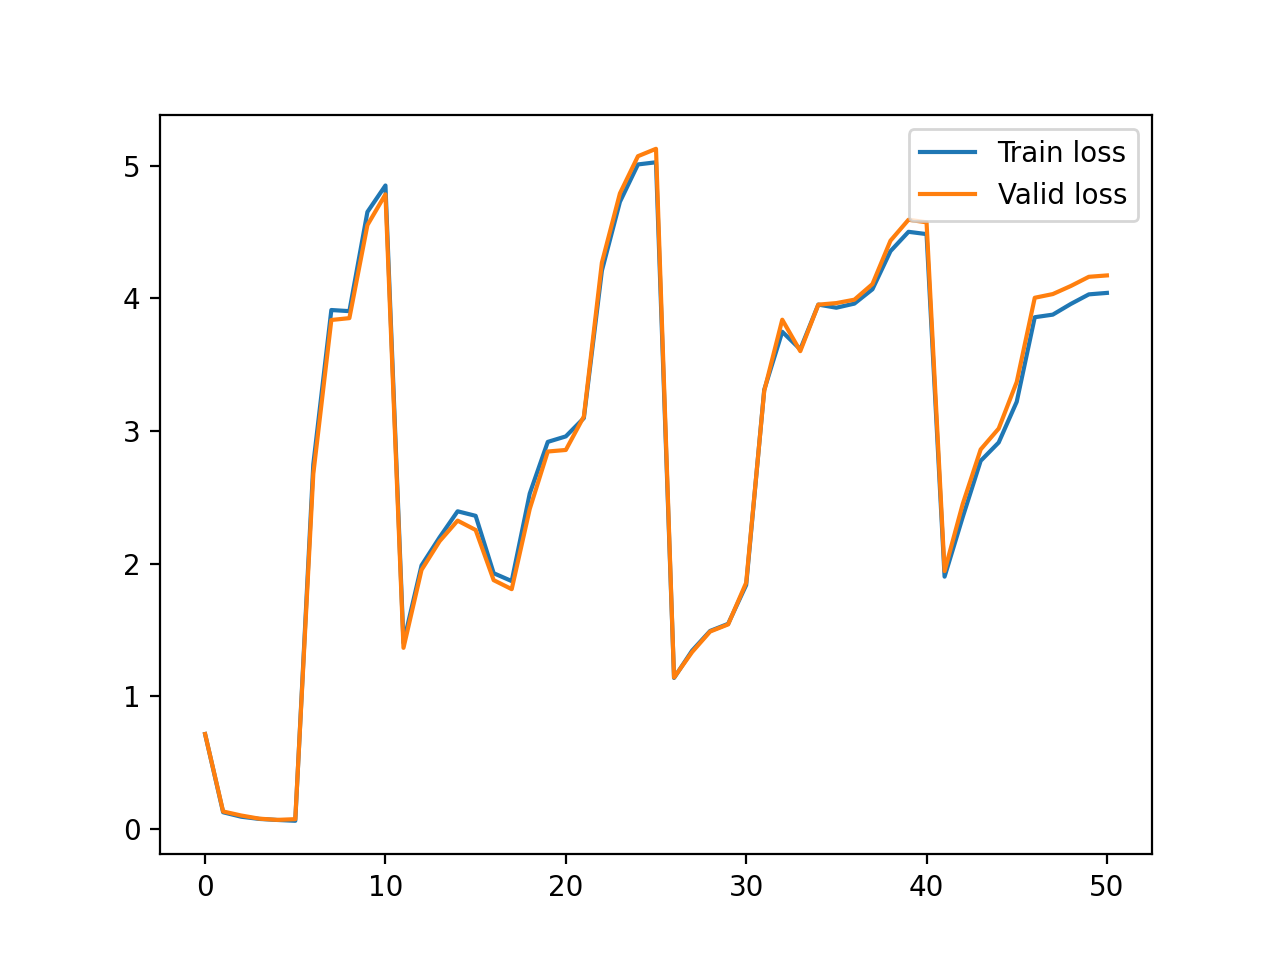

In [18]:
%matplotlib notebook
plt.plot(data_dict['train_loss'][0], label='Train loss')
plt.plot(data_dict['valid_loss'][0], label='Valid loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
len(data_dict['train_loss'])

2

<IPython.core.display.Javascript object>


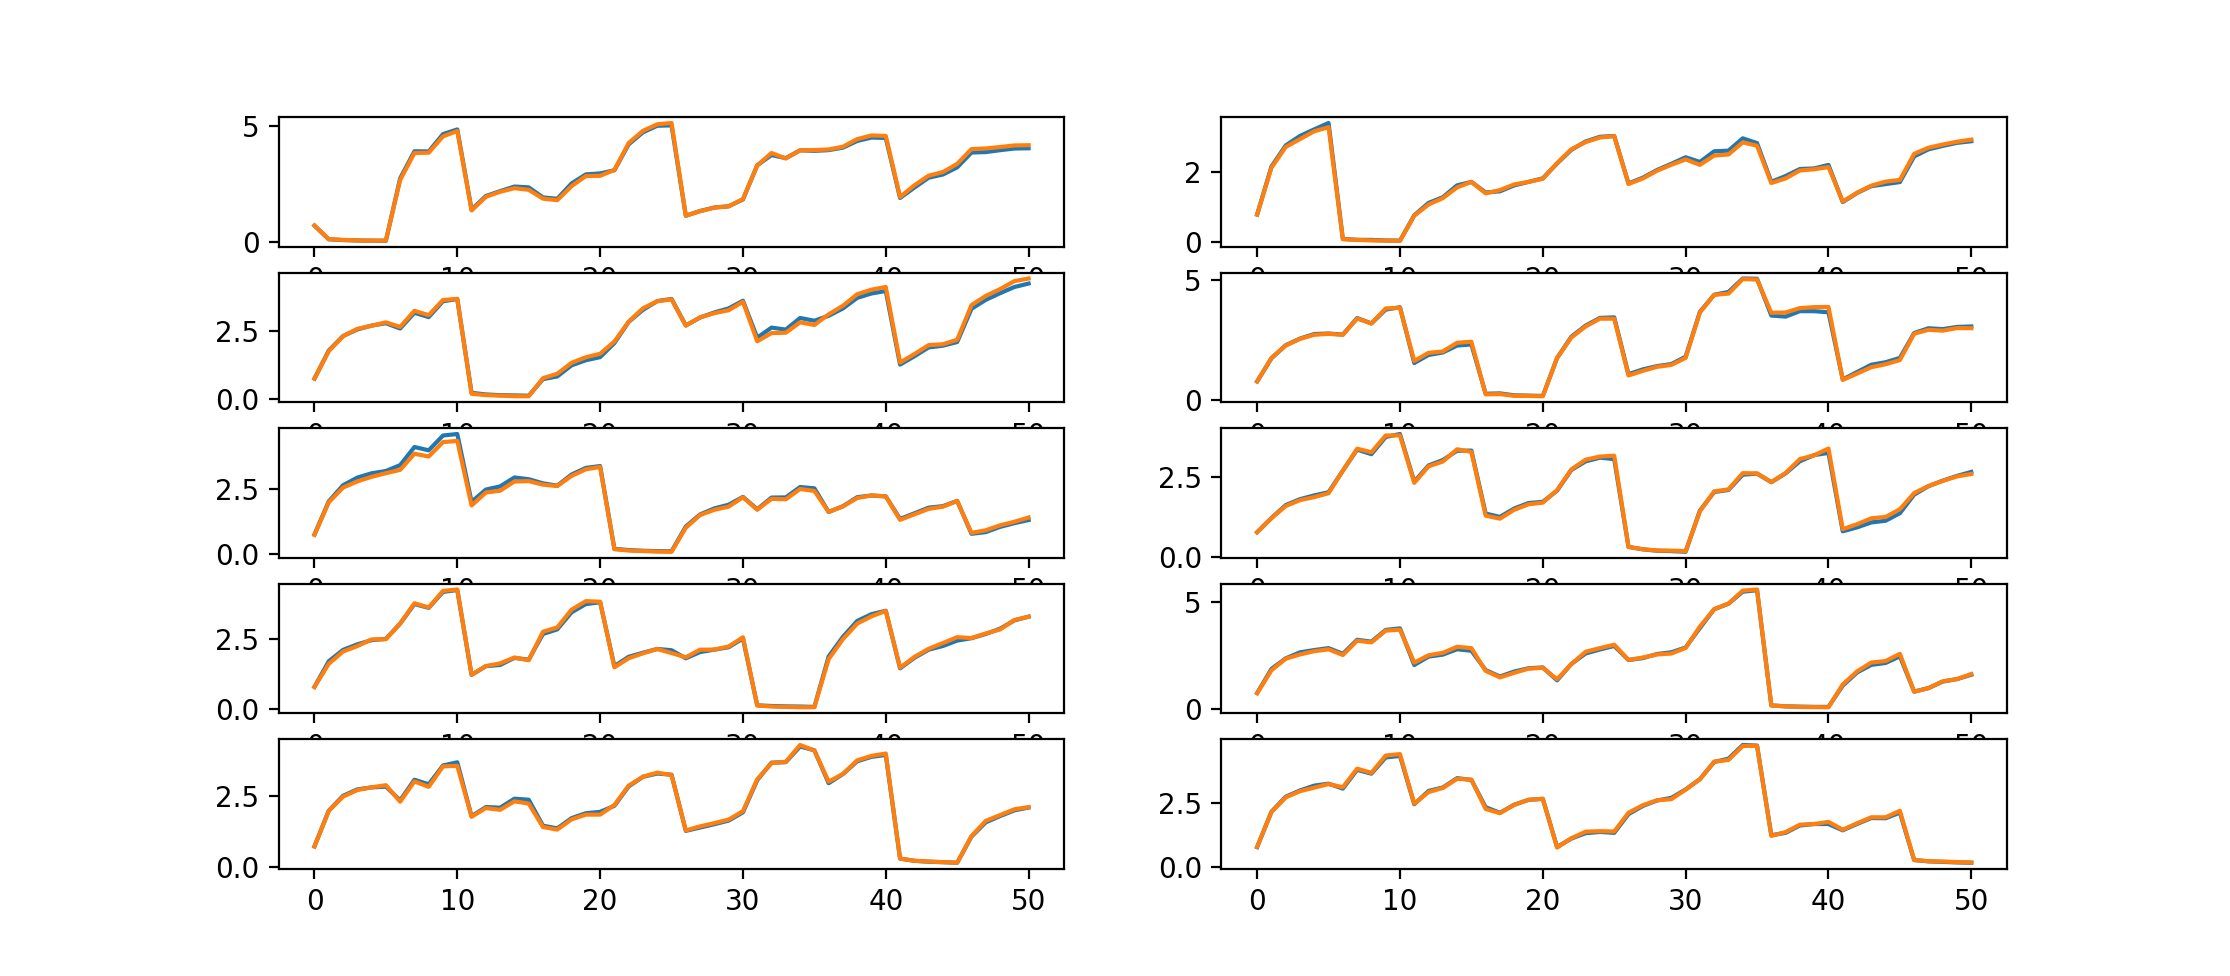

In [19]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_loss'][count])
        ax[r,c].plot(data_dict['valid_loss'][count])
        count += 1
plt.show()

<IPython.core.display.Javascript object>


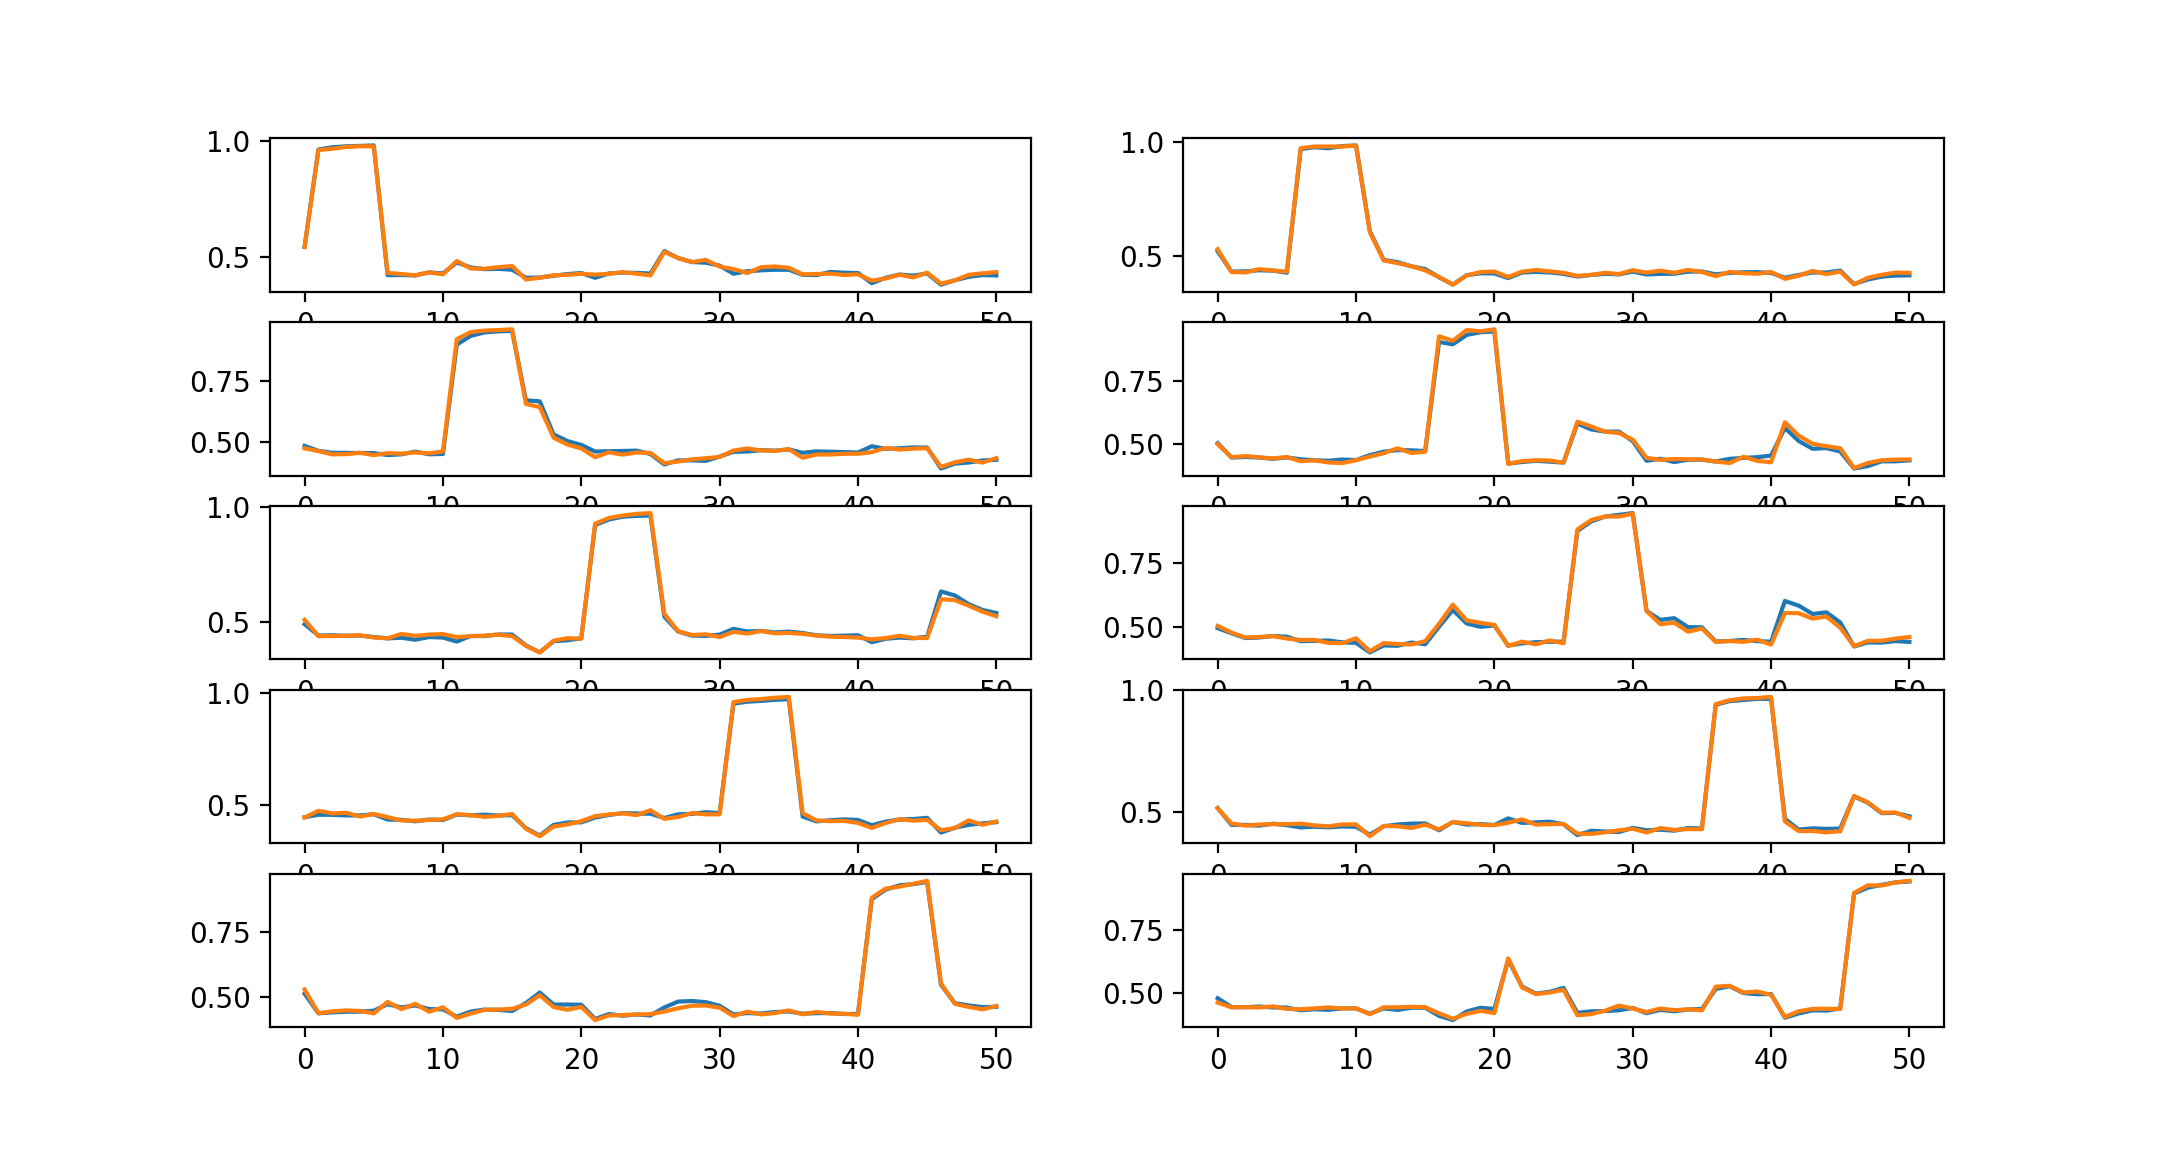

In [21]:
%matplotlib notebook
fig, ax = plt.subplots(nrows=5, ncols=2)
count = 0
for r in range(5):
    for c in range(2):
        ax[r,c].plot(data_dict['train_acc'][count])
        ax[r,c].plot(data_dict['valid_acc'][count])
        count += 1
plt.show()